In [ ]:
clear

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 시간정보를 활용하여 폴더 생성
import datetime 

In [ ]:
data = np.load('/content/drive/MyDrive/dataset/augmented_Spectogram/train.npz')
X_train = data['array1']
Y_train = data['array2']

data = np.load('/content/drive/MyDrive/dataset/augmented_Spectogram/test.npz')
argumented_X_test = data['array1']
argumented_Y_test = data['array2']

In [ ]:
#print(X_train.shape)
val_size = int(X_train.shape[0]/5)
#print(val_size)

k = 5 # k 는 1에서 5
argumented_X_val = X_train[val_size*(k-1):val_size*k, :, :, :]
argumented_Y_val = Y_train[val_size*(k-1):val_size*k]

argumented_X_train = np.concatenate((X_train[:val_size*(k-1), :, :, :] , X_train[val_size*k:, :, :, :] ),axis=0)
argumented_Y_train = np.concatenate((Y_train[:val_size*(k-1)] , Y_train[val_size*k:]),axis=0)

print(argumented_X_train.shape)
print(argumented_X_val.shape)
print(argumented_X_test.shape)

print(argumented_Y_train.shape)
print(argumented_Y_val.shape)
print(argumented_Y_test.shape)

print(argumented_Y_test[0])

(3600, 428, 81, 3)
(900, 428, 81, 3)
(500, 428, 81, 3)
(3600, 5)
(900, 5)
(500, 5)
[0. 0. 0. 0. 1.]


In [ ]:
# 상수
BATCH_SIZE =  100
EPOCHS = 50
NUM_CLASSES = 5
VERBOSE = 1

INPUT_SHAPE = (428, 81, 3)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, LSTM

model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape= INPUT_SHAPE))
model.add(Conv1D(32, kernel_size=3, activation='relu'))

model.add(Reshape((428*77, 32)))
model.add(LSTM(16, return_sequences=True))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.summary()
OPTIM = tf.keras.optimizers.RMSprop()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 428, 79, 64)       640       
                                                                 
 conv1d_1 (Conv1D)           (None, 428, 77, 32)       6176      
                                                                 
 reshape (Reshape)           (None, 32956, 32)         0         
                                                                 
 lstm (LSTM)                 (None, 32956, 16)         3136      
                                                                 
 flatten (Flatten)           (None, 527296)            0         
                                                                 
 dense (Dense)               (None, 5)                 2636485   
                                                                 
Total params: 2,646,437
Trainable params: 2,646,437
Non-

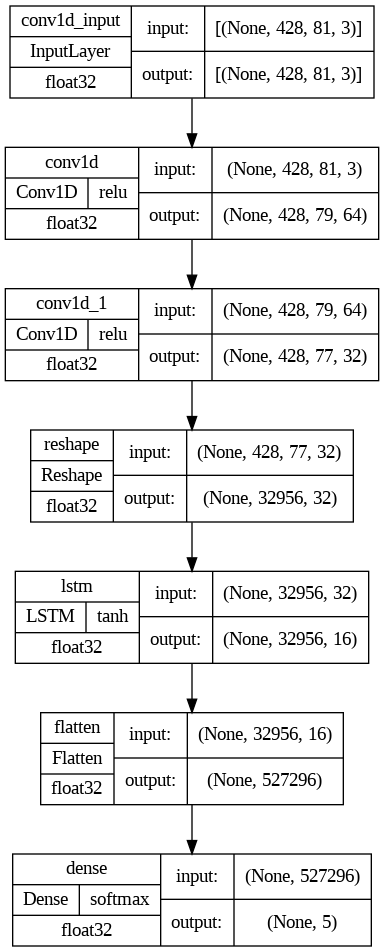

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(
    model,
    to_file="/content/drive/MyDrive/model/coughdetection/lstm_" + str(k) + ".png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    show_layer_activations=True,
)

In [ ]:
# 텐서보드 사용
callbacks = [
    # 텐서보드 로그를 './logs' 디렉터리에 작성
    tf.keras.callbacks.TensorBoard(log_dir = './logs')
]

# 학습데이터의 log를 저장할 폴더 생성 (지정)
log_dir = "logs/my_board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 텐서보드 콜백 정의 하기
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
history = model.fit(argumented_X_train, argumented_Y_train,
                    batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_data = (argumented_X_val, argumented_Y_val),
                    callbacks = [tensorboard_callback])

score = model.evaluate(argumented_X_test, argumented_Y_test, batch_size = BATCH_SIZE)
print("\nTest score:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
36/36 [==============================] - 49s 951ms/step - loss: 60.9425 - accuracy: 0.2692 - val_loss: 22.8322 - val_accuracy: 0.2000
Epoch 2/50
36/36 [==============================] - 34s 961ms/step - loss: 7.3062 - accuracy: 0.4922 - val_loss: 2.3771 - val_accuracy: 0.5967
Epoch 3/50
36/36 [==============================] - 35s 972ms/step - loss: 2.1861 - accuracy: 0.7075 - val_loss: 1.7454 - val_accuracy: 0.6711
Epoch 4/50
36/36 [==============================] - 35s 969ms/step - loss: 0.4458 - accuracy: 0.8792 - val_loss: 0.6245 - val_accuracy: 0.8456
Epoch 5/50
36/36 [==============================] - 33s 909ms/step - loss: 0.1887 - accuracy: 0.9311 - val_loss: 0.3700 - val_accuracy: 0.8989
Epoch 6/50
36/36 [==============================] - 35s 974ms/step - loss: 0.1934 - accuracy: 0.9336 - val_loss: 0.6752 - val_accuracy: 0.8000
Epoch 7/50
36/36 [==============================] - 35s 972ms/step - loss: 0.3144 - accuracy: 0.9147 - val_loss: 0.2617 - val_accuracy: 0.92

In [ ]:
    # 모델 저장
model_title = "/content/drive/MyDrive/model/coughdetection/lstm_" + str(k) + ".json"
weights_title = '/content/drive/MyDrive/model/coughdetection/lstm_weights_' + str(k) + ".json"

model_json = model.to_json()
with open(model_title, 'w') as json_file:
  json_file.write(model_json)
model.save_weights(weights_title)

